In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.9 MB/s eta 0:00:00


In [3]:
import cv2 as cv
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

### Remeber that opencv reads images in BGR FORMAT AND MATPLOTLIB READS IMAGES IN RGB FORMAT

In [ ]:
img = cv.imread('ronaldo.jfif')

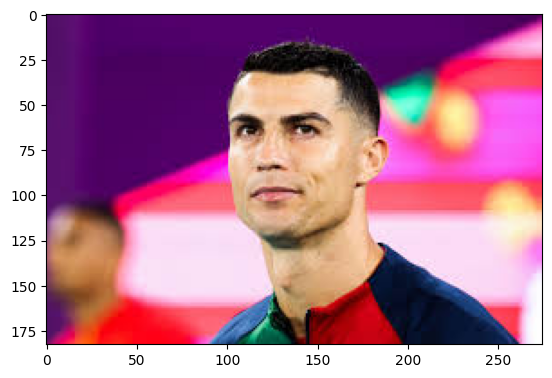

In [ ]:
img = cv.cvtColor(img,cv.COLOR_BGR2RGB) # converting from BGR TO RGB FOR MATPLOTLIB
plt.imshow(img)

In [4]:
from mtcnn.mtcnn import MTCNN

In [ ]:


detector = MTCNN()
results = detector.detect_faces(img)
results

1/1 [==============================] - 0s 169ms/step


[{'box': [101, 30, 69, 94],
  'confidence': 0.9990584254264832,
  'keypoints': {'left_eye': (112, 65),
   'right_eye': (143, 64),
   'nose': (121, 81),
   'mouth_left': (114, 100),
   'mouth_right': (142, 98)}}]

In [ ]:
x,y,w,h = results[0]['box']

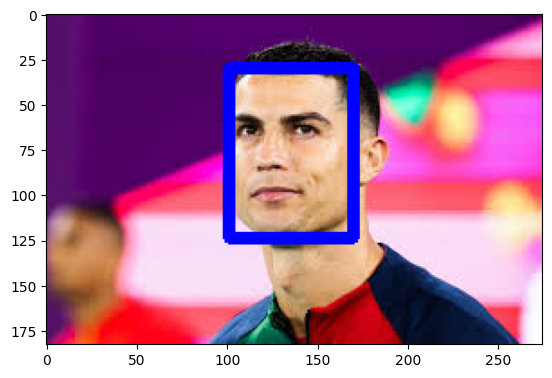

In [ ]:
face = cv.rectangle(img,(x,y),(x+w,y+h),(0,0,255),5)
plt.imshow(face)

### Facenet takes as input an 160X160 image

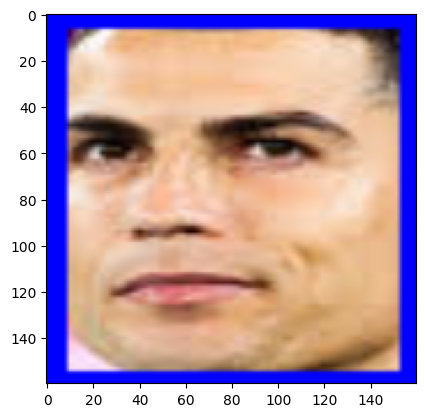

In [ ]:
face = img[y:y+h,x:x+w]
face = cv.resize(face,(160,160))
plt.imshow(face)

## Automate the Preprocessing

In [5]:
class FaceLoading:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()
    

    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x,y,w,h = self.detector.detect_faces(img)[0]['box']
        x,y = abs(x), abs(y)
        face = img[y:y+h, x:x+w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr
    

    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)
        
        return np.asarray(self.X), np.asarray(self.Y)


    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num,image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows,ncols,num+1)
            plt.imshow(image)
            plt.axis('off')

In [10]:
faceloading = FaceLoading("/content/drive/MyDrive/facerecog_new/dataset")
X, Y = faceloading.load_classes()

1/1 [==============================] - 0s 30ms/step
Loaded successfully: 15
1/1 [==============================] - 0s 50ms/step
Loaded successfully: 10
1/1 [==============================] - 0s 35ms/step
Loaded successfully: 10
1/1 [==============================] - 0s 42ms/step
Loaded successfully: 10
1/1 [==============================] - 0s 46ms/step
Loaded successfully: 9
1/1 [==============================] - 0s 28ms/step
Loaded successfully: 10


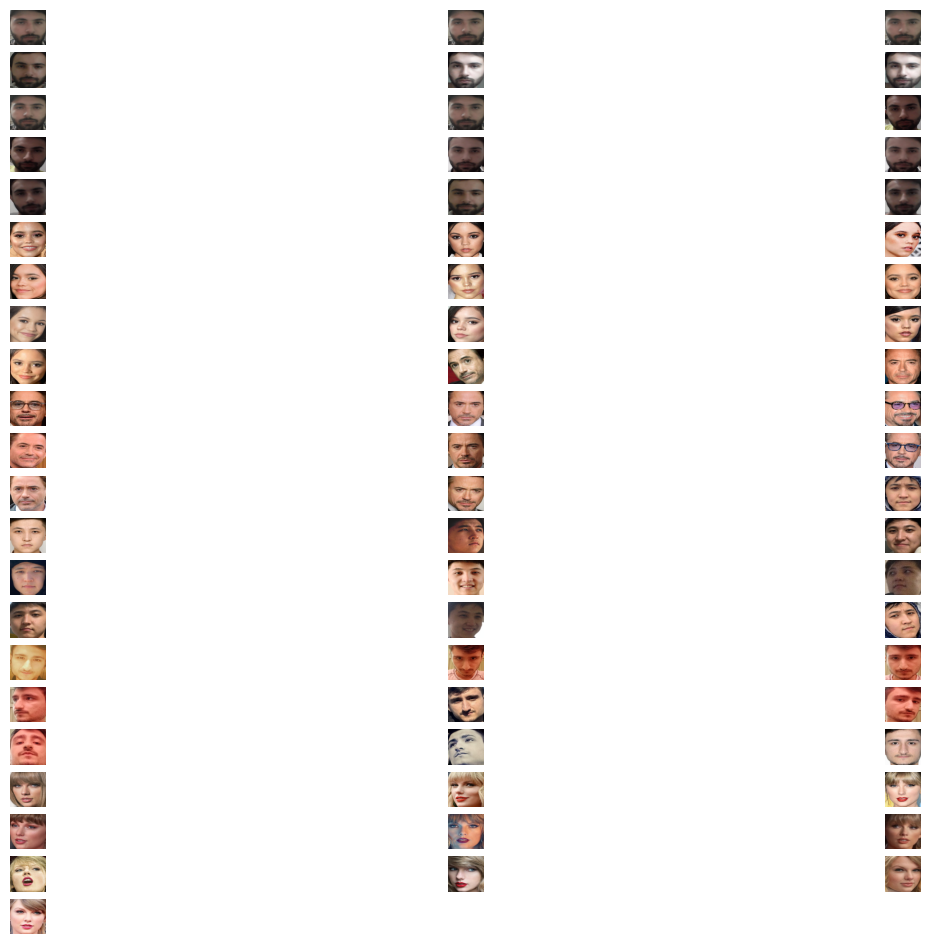

In [11]:
plt.figure(figsize=(16,12))
for num,image in enumerate(X):
    ncols = 3
    nrows = len(Y)//ncols + 1
    plt.subplot(nrows,ncols,num+1)
    plt.imshow(image)
    plt.axis('off')

# FaceNet

In [12]:
!pip install keras-facenet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10385 sha256=329bd2b6da35c34a78cb586e699c524605ddac024b5a475730974f884c52f5b8
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


In [13]:
from keras_facenet import FaceNet
embedder = FaceNet()

In [15]:
def get_embedding(face_img):
      face_img = face_img.astype('float32') # 3D(160x160x3)
      face_img = np.expand_dims(face_img, axis=0) # bcz tensorflow requires 4 dimensions
      # 4D (Nonex160x160x3)
      yhat= embedder.embeddings(face_img)
      return yhat[0] # 512D image (1x1x512)

In [16]:
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 [==============================] - 0s 184ms/step


In [17]:
np.savez_compressed('faces_embeddings_done_6classes.npz', EMBEDDED_X, Y) # Save several arrays into a single file in compressed .npz format.

In [18]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

Text(0, 0.5, '0')

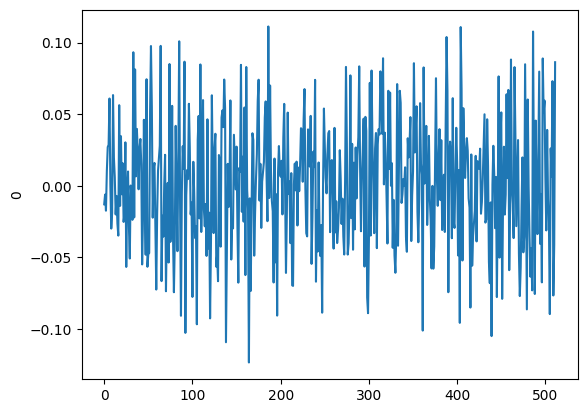

In [19]:
plt.plot(EMBEDDED_X[0]) 
plt.ylabel(Y[0])

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, shuffle=True, random_state=17)

In [28]:
print(len(X_train[0]))

512


In [29]:
import numpy as np
np.shape(X_train[0])

(512,)

In [39]:
np.shape(Y_train[0])

()

In [40]:
Y_train

array([5, 2, 2, 0, 5, 0, 3, 2, 0, 2, 3, 1, 1, 4, 4, 1, 0, 0, 0, 2, 5, 2,
       3, 3, 2, 5, 0, 2, 0, 3, 1, 4, 0, 0, 3, 1, 3, 0, 2, 5, 4, 4, 5, 1,
       0, 1, 4, 4])

In [41]:
y_train_one_hot = np.eye(6)[Y_train]
y_test_one_hot = np.eye(6)[Y_test]

In [42]:
y_train_one_hot[0]

array([0., 0., 0., 0., 0., 1.])

In [57]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [44]:
input_shape = (512,)

In [45]:
num_classes = 6

In [58]:
nn_model = Sequential([
    Dense(256, activation='relu', input_shape=input_shape,kernel_regularizer=regularizers.l2(0.01)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [59]:
nn_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [60]:
history = nn_model.fit(X_train, y_train_one_hot,
                    batch_size=16,
                    epochs=20,
                    validation_data=(X_test, y_test_one_hot))

Epoch 1/20
3/3 [==============================] - 1s 118ms/step - loss: 5.0808 - accuracy: 0.1667 - val_loss: 4.8601 - val_accuracy: 0.3125
Epoch 2/20
3/3 [==============================] - 0s 29ms/step - loss: 4.7178 - accuracy: 0.4375 - val_loss: 4.5298 - val_accuracy: 0.3750
Epoch 3/20
3/3 [==============================] - 0s 20ms/step - loss: 4.3604 - accuracy: 0.5833 - val_loss: 4.2060 - val_accuracy: 0.4375
Epoch 4/20
3/3 [==============================] - 0s 20ms/step - loss: 3.9981 - accuracy: 0.5833 - val_loss: 3.8806 - val_accuracy: 0.4375
Epoch 5/20
3/3 [==============================] - 0s 28ms/step - loss: 3.6272 - accuracy: 0.6042 - val_loss: 3.5533 - val_accuracy: 0.4375
Epoch 6/20
3/3 [==============================] - 0s 29ms/step - loss: 3.2653 - accuracy: 0.6250 - val_loss: 3.2298 - val_accuracy: 0.4375
Epoch 7/20
3/3 [==============================] - 0s 29ms/step - loss: 2.9097 - accuracy: 0.7083 - val_loss: 2.9085 - val_accuracy: 0.6875
Epoch 8/20
3/3 [==========

[]

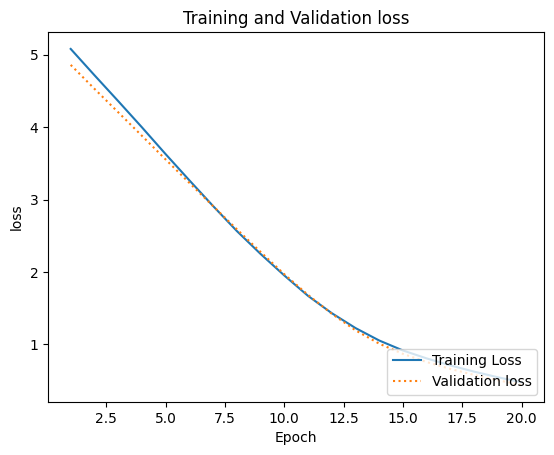

In [61]:
acc = history.history['loss']
val_acc = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Loss')
plt.plot(epochs, val_acc, ':', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')
plt.plot()

In [62]:
nn_model.save('final_face_model2.h5')

In [55]:
im = cv.imread("/content/Akshay_Kumar.jpg")

In [21]:
from sklearn.svm import SVC
model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

In [22]:
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)

In [23]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_train, ypreds_train)

1.0

In [24]:
accuracy_score(Y_test,ypreds_test)

1.0

In [25]:
import pickle
#save the model
with open('svm_model2_160x160.pkl','wb') as f:
    pickle.dump(model,f)

In [ ]:
model.predict()

In [26]:
im = cv.imread("/content/Akshay_Kumar.jpg")

### Real time test1

In [ ]:
t_im = cv.imread("/content/Akshay_Kumar.jpg")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(t_im)[0]['box']

1/1 [==============================] - 0s 38ms/step


In [ ]:
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)

1/1 [==============================] - 0s 110ms/step


In [ ]:
test_im = [test_im]
ypreds = model.predict(test_im)

In [ ]:
ypreds

array([0])

In [ ]:
encoder.inverse_transform(ypreds)

array(['azam'], dtype='<U18')

## Real time test2

In [ ]:
t_im = cv.imread("test2.jpg")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(t_im)[0]['box']

1/1 [==============================] - 0s 121ms/step


In [ ]:
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)

1/1 [==============================] - 0s 211ms/step


In [ ]:
test_im = [test_im]
ypreds = model.predict(test_im)

In [ ]:
ypreds

array([0])

In [ ]:
encoder.inverse_transform(ypreds)

array(['azam'], dtype='<U18')